In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import string
import re
from spellchecker import SpellChecker

## Load data

In [2]:
DATA_DIR = "../data/commonlit-evaluate-student-summaries/"
prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

In [3]:
train = summaries_train.join(prompts_train.set_index("prompt_id"), on="prompt_id", how="left")
test = summaries_test.join(prompts_test.set_index("prompt_id"), on="prompt_id", how="left")

In [4]:
train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [5]:
test.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
2,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


## Evaluation

In [6]:
def mcrmse(target, prediction):
    assert type(target) == np.ndarray, "Target must be numpy array"
    assert type(prediction) == np.ndarray, "Prediction must be numpy array"
    assert target.shape == prediction.shape, "Target and prediction must have the same shape"
    columns = np.sqrt(np.sum(np.power(target-prediction, 2), axis=0)/target.shape[0])
    return np.sum(columns, axis=0)/target.shape[1]

In [7]:
mcrmse(train[['content', 'wording']].to_numpy(), train[['content', 'wording']].to_numpy())

0.0

## Data preparation

In [8]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/mykyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mykyta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def filter_stop_words(text):
    result = []
    for token in nltk.tokenize.word_tokenize(text.lower()):
        if token not in stop_words and token not in string.punctuation:
            result.append(token)
    return " ".join(result)

def filter(df):
    df['filtered_prompt'] = df['prompt_text'].apply(filter_stop_words)
    df['filtered_text'] = df['text'].apply(filter_stop_words)

In [11]:
filter(train)

In [12]:
unfiltered_word_cloud_prompt = WordCloud(width=800, height=400).generate(" ".join(train['prompt_text']))
filtered_word_cloud_prompt = WordCloud(width=800, height=400).generate(" ".join(train['filtered_prompt']))
unfiltered_word_cloud_text = WordCloud(width=800, height=400).generate(" ".join(train['text']))
filtered_word_cloud_text = WordCloud(width=800, height=400).generate(" ".join(train['filtered_text']))

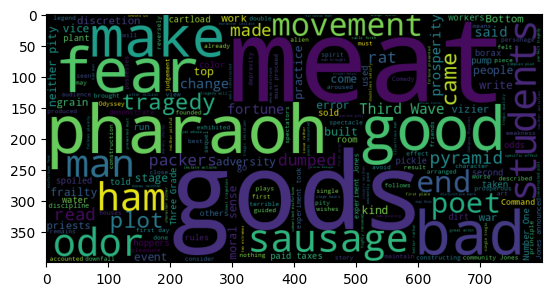

In [13]:
plt.imshow(unfiltered_word_cloud_prompt);

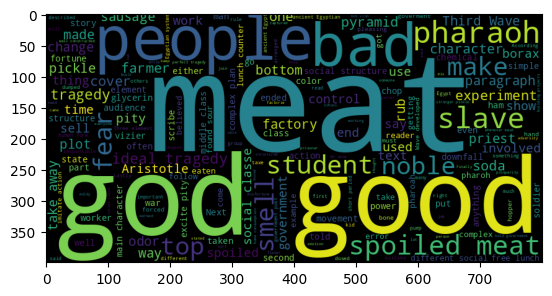

In [14]:
plt.imshow(unfiltered_word_cloud_text);

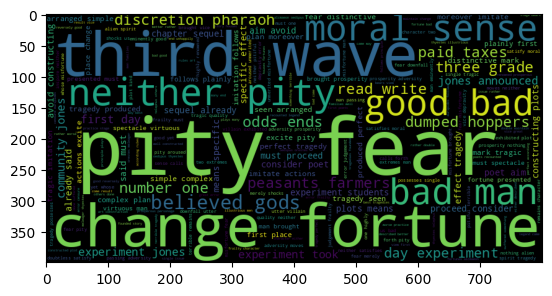

In [15]:
plt.imshow(filtered_word_cloud_prompt);

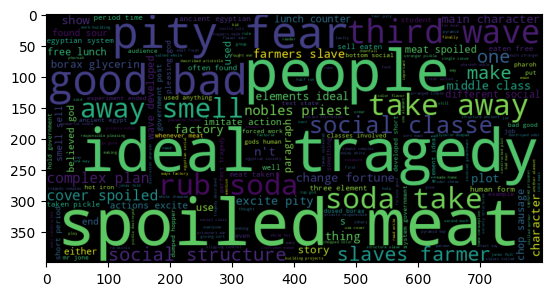

In [16]:
plt.imshow(filtered_word_cloud_text);

In [17]:
def add_len(df):
    df['text_len'] = df['filtered_text'].apply(len)
    df['prompt_len'] = df['filtered_prompt'].apply(len)

In [18]:
add_len(train)

In [19]:
train[['text_len', 'prompt_len', 'content', 'wording']].corr()

,text_len,prompt_len,content,wording
text_len,1.000000,0.044893,0.792548,0.530569
prompt_len,0.044893,1.000000,-0.010228,-0.072696
content,0.792548,-0.010228,1.000000,0.751380
wording,0.530569,-0.072696,0.751380,1.000000


Text len is very correlated with content score, but not with wording

In [20]:
def add_features(df):
    df['text_unique_word_num'] = df['filtered_text'].apply(lambda s: len(set(s.split(" "))))
    df['word_overlap_num'] = df.apply(lambda r: len([w for w in r['filtered_text'].split(" ") if w in r['filtered_prompt'].split(" ")]), axis=1)
    spell_checker = SpellChecker()
    df['misspeled_word_num'] = df['filtered_text'].apply(lambda s: spell_checker.unknown(s.split(" "))).apply(len)
    df['text_mean_word_len'] = df['filtered_text'].apply(lambda s: np.mean([len(w) for w in s.split(" ")]))
    df['quotes_len'] = df['text'].apply(lambda s: len(re.findall(r'"([^"]*)"', s)))
    df['merged_text'] = df['prompt_title'] + "<SEP>" + train['filtered_prompt'] + "<SEP>" + df['filtered_text']

In [21]:
add_features(train)

In [22]:
train[['text_len', 'prompt_len', 'text_unique_word_num', 'word_overlap_num', 'misspeled_word_num', 'text_mean_word_len', 'quotes_len', 'content', 'wording']].corr()

,text_len,prompt_len,text_unique_word_num,word_overlap_num,misspeled_word_num,text_mean_word_len,quotes_len,content,wording
text_len,1.000000,0.044893,0.978029,0.906639,0.603775,0.103688,0.579211,0.792548,0.530569
prompt_len,0.044893,1.000000,0.108907,0.219022,0.102432,-0.531290,0.192794,-0.010228,-0.072696
text_unique_word_num,0.978029,0.108907,1.000000,0.911298,0.627243,0.031332,0.567471,0.791804,0.514267
word_overlap_num,0.906639,0.219022,0.911298,1.000000,0.523809,-0.066352,0.600189,0.669380,0.316427
misspeled_word_num,0.603775,0.102432,0.627243,0.523809,1.000000,0.008509,0.471500,0.456902,0.257333
text_mean_word_len,0.103688,-0.531290,0.031332,-0.066352,0.008509,1.000000,-0.212841,0.097769,0.150846
quotes_len,0.579211,0.192794,0.567471,0.600189,0.471500,-0.212841,1.000000,0.458936,0.217965
content,0.792548,-0.010228,0.791804,0.669380,0.456902,0.097769,0.458936,1.000000,0.751380
wording,0.530569,-0.072696,0.514267,0.316427,0.257333,0.150846,0.217965,0.751380,1.000000


## Modeling

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['content', 'wording']), train[['content', 'wording']])

In [24]:
column_transformer = ColumnTransformer([('text', TfidfVectorizer(lowercase=True, min_df=3), 'merged_text'),
                                        ('text_len', StandardScaler(), ['text_len']),
                                        ('prompt_len', StandardScaler(), ['prompt_len']),
                                        ('text_unique_word_num', StandardScaler(), ['text_unique_word_num']),
                                        ('word_overlap_num', StandardScaler(), ['word_overlap_num']),
                                        ('misspeled_word_num', StandardScaler(), ['misspeled_word_num']),
                                        ('text_mean_word_len', StandardScaler(), ['text_mean_word_len']),
                                        ('quotes_len', StandardScaler(), ['quotes_len'])])
model = Pipeline([
    ('transformer', column_transformer),
    ('regressor', RandomForestRegressor(n_jobs=-1))
])
model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(min_df=3),
                                                  'merged_text'),
                                                 ('text_len', StandardScaler(),
                                                  ['text_len']),
                                                 ('prompt_len',
                                                  StandardScaler(),
                                                  ['prompt_len']),
                                                 ('text_unique_word_num',
                                                  StandardScaler(),
                                                  ['text_unique_word_num']),
                                                 ('word_overlap_num',
                                                  StandardScaler(),
                                                  ['word_overlap_num']),
                                                 ('misspeled_word_num',
                                                  StandardScaler(),
                                                  ['misspeled_word_num']),
                                                 ('text_mean_word_len',
                                                  StandardScaler(),
                                                  ['text_mean_word_len']),
                                                 ('quotes_len',
                                                  StandardScaler(),
                                                  ['quotes_len'])])),
                ('regressor', RandomForestRegressor(n_jobs=-1))])

In [25]:
sklearn.metrics.mean_squared_error(y_train, model.predict(X_train), squared=False)

0.21069809010184332

In [26]:
prediction = model.predict(X_test)
sklearn.metrics.mean_squared_error(y_test, prediction, squared=False)

0.5686816641899198

In [27]:
filter(test)
add_len(test)
add_features(test)

In [28]:
test_prediction = model.predict(test)

In [29]:
result = pd.concat((test['student_id'], pd.DataFrame(test_prediction, columns=['content', 'wording'])), axis=1)

In [30]:
result

,student_id,content,wording
0,000000ffffff,-1.279958,-1.114472
1,111111eeeeee,-1.369728,-0.924497
2,222222cccccc,-1.449233,-0.976900
3,333333dddddd,-1.449233,-0.976900
